In [89]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import seaborn as sb
import missingno as msno
import warnings
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder,PowerTransformer,MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, plot_roc_curve, precision_recall_curve
from sklearn.metrics import auc, accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from skopt import gp_minimize
from skopt import space
from skopt.plots import plot_convergence
from functools import partial
from collections import Counter
from scipy import stats
from scipy.stats import norm, skew


import warnings
warnings.filterwarnings("ignore")

df_train = pd.read_csv("aug_train.csv")
# df_train.shape

In [90]:
df_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0


In [91]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  int64  
dtypes: float64(1), int64(3), object(10)
me

In [92]:
df_train.last_new_job.value_counts()

1        8040
>4       3290
2        2900
never    2452
4        1029
3        1024
Name: last_new_job, dtype: int64

0    14381
1     4777
Name: target, dtype: int64


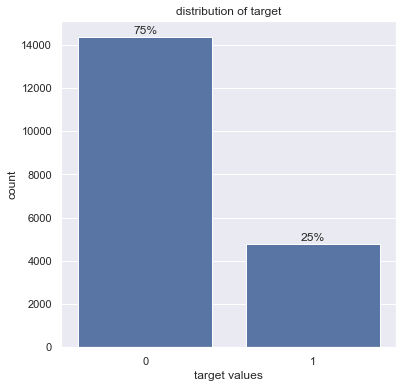

In [93]:
count = df_train.target.value_counts()
print( count )
plt.figure(figsize = (6,6))
sb.countplot(df_train.target,color = sb.color_palette()[0]);
plt.title('distribution of target');
plt.xlabel('target values');
plt.ylabel('count');
for i in range(count.shape[0]):
    plt.text( 
            i,
            count[i] + 500,
            str(round(100*count[i] /df_train.target.count()))+'%',
              ha='center',
              va = 'top')

We can notice that the data is imbalanced

In [94]:
df_pre = df_train
df_pre.shape

(19158, 14)

In [95]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  int64  
dtypes: float64(1), int64(3), object(10)
me

In [96]:
# plt.subplots(figsize=(20,15))
# sb.heatmap(df_pre.corr(),annot_kws={"size": 10} ,annot=True,cmap='YlGnBu',)

In [97]:
df_pre['city'].value_counts()

city_103    4355
city_21     2702
city_16     1533
city_114    1336
city_160     845
            ... 
city_129       3
city_111       3
city_121       3
city_140       1
city_171       1
Name: city, Length: 123, dtype: int64

In [98]:
# df_pre.drop(["city"], axis=1, inplace = True)

In [99]:
df_pre['company_size'] = df_pre['company_size'].replace('10-49', np.nan)
df_pre['company_size'].value_counts()

50-99        3083
100-500      2571
10000+       2019
10/49        1471
1000-4999    1328
<10          1308
500-999       877
5000-9999     563
Name: company_size, dtype: int64

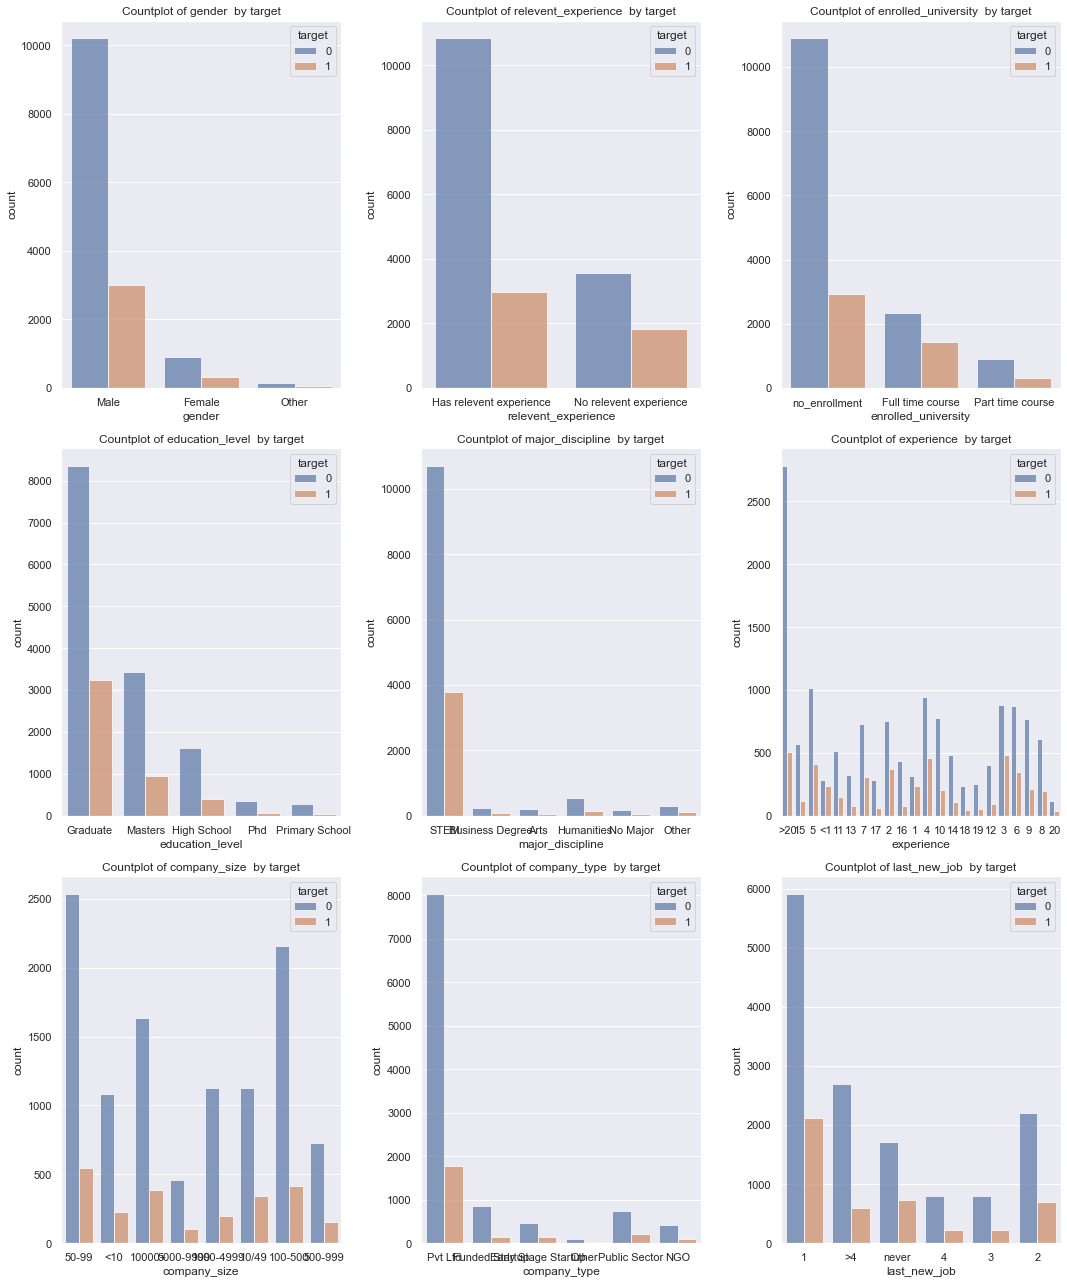

In [100]:
#Frequency of each category separated by label
plt.figure(figsize=[15,18])
feafures = ['gender','relevent_experience','enrolled_university','education_level', 'major_discipline',
       'experience','company_size','company_type','last_new_job']
n=1
for f in feafures:
    plt.subplot(3,3,n)
    sns.countplot(x=f, hue='target', alpha=0.7, data=df_train)
    plt.title("Countplot of {}  by target".format(f))
    n=n+1
plt.tight_layout()
plt.show()

#### Number of rows contains at least one missing value

(19158, 14)


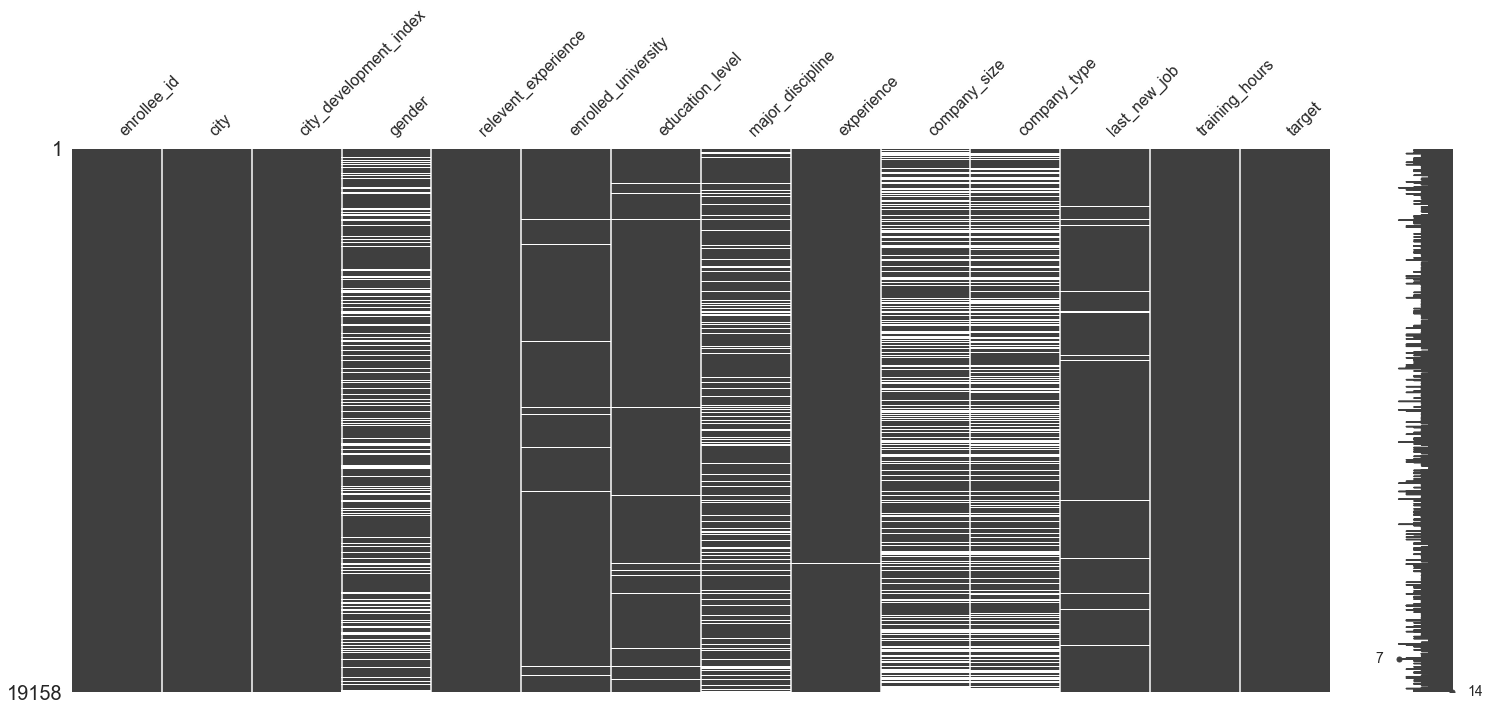

In [101]:
print(df_pre.shape)
msno.matrix(df_pre);

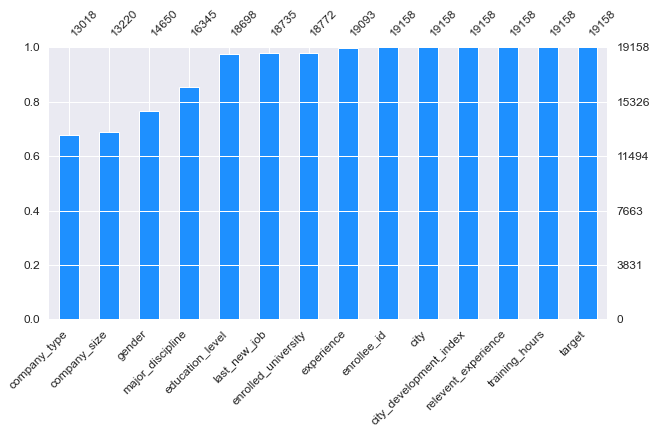

In [102]:
msno.bar(df_pre,color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

 Columns that contain missing values

In [103]:
null = pd.DataFrame({'No of null values':df_train.isnull().sum(),'Percentage of null values':df_train.isnull().sum()*100/df_train.shape[0]})
# null 
null[null['No of null values'] > 0]

,No of null values,Percentage of null values
gender,4508,23.530640
enrolled_university,386,2.014824
education_level,460,2.401086
major_discipline,2813,14.683161
experience,65,0.339284
company_size,5938,30.994885
company_type,6140,32.049274
last_new_job,423,2.207955


The percentage of missing values is very high so we can not drop these rows.

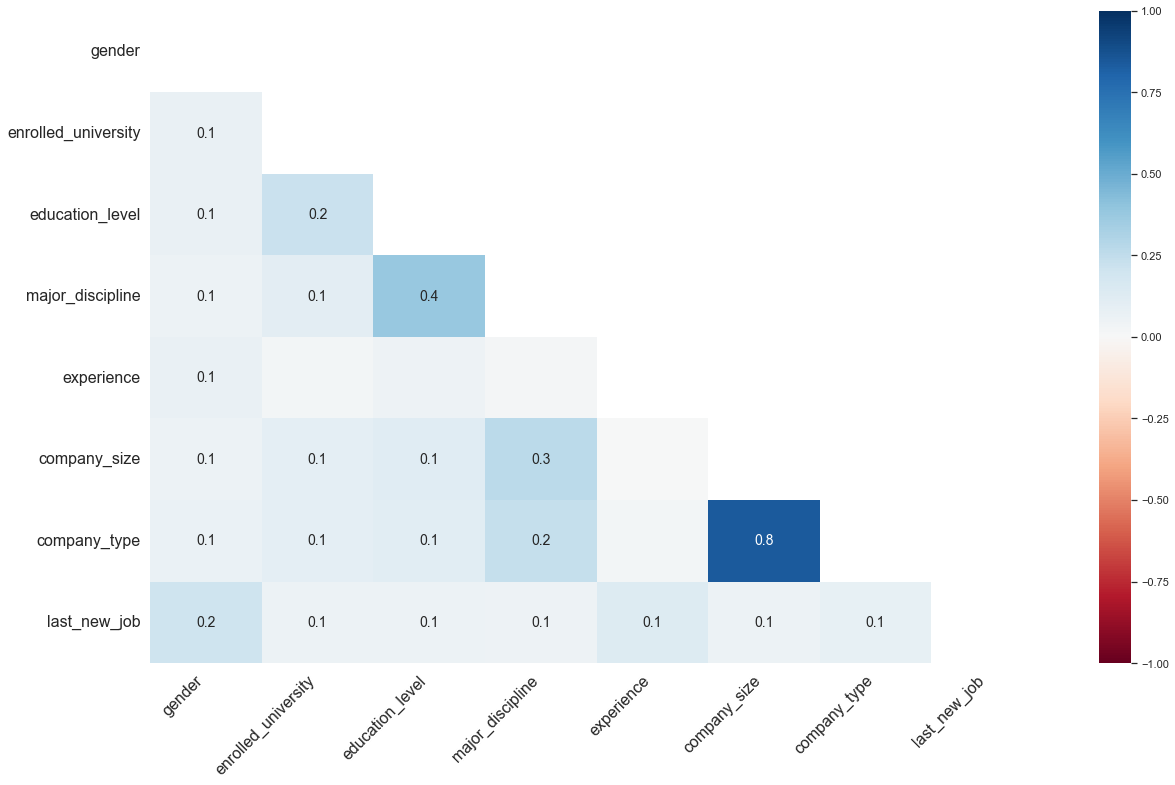

In [104]:
# plotting heatmap showing nullity correlation between various columns of dataset.
msno.heatmap(df_pre);

Number of rows: 8955
Percentage of rows that contains missing values: 46.74287503914814


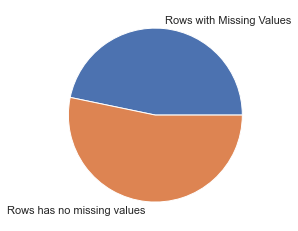

In [105]:
x = df_train.dropna()
total = df_train.shape[0]
missing = x.shape[0]
print('Number of rows:' ,  missing )
print('Percentage of rows that contains missing values:', (missing ) *100 / total )

a = (missing ) *100 / total
b = 100 - (missing ) *100 / total

y=np.array([a,b])
plt.pie(y,  labels = ["Rows with Missing Values", "Rows has no missing values"])
plt.show()

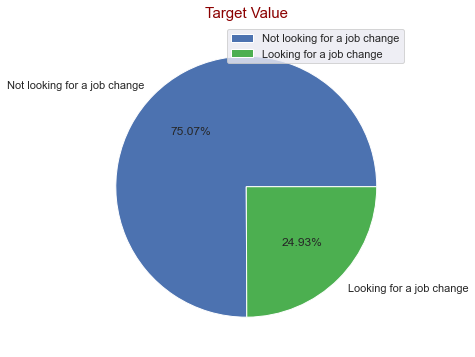

In [106]:
#relevent_experience
target = df_train["target"].value_counts()

target_values = target.values

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
colrs= [ "b", "#4CAF50"]
plt.pie(target_values, labels=["Not looking for a job change", "Looking for a job change"], autopct='%1.2f%%',colors=colrs)
plt.title('Target Value',color = 'darkred',fontsize = 15)
plt.legend()

## Training Hours

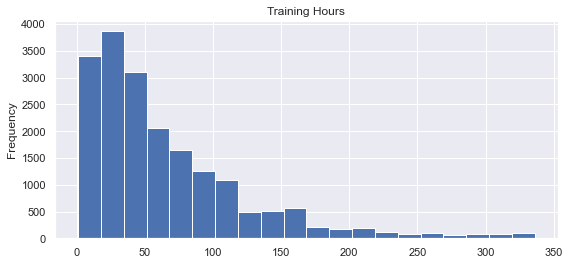

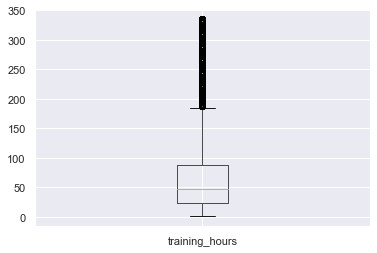

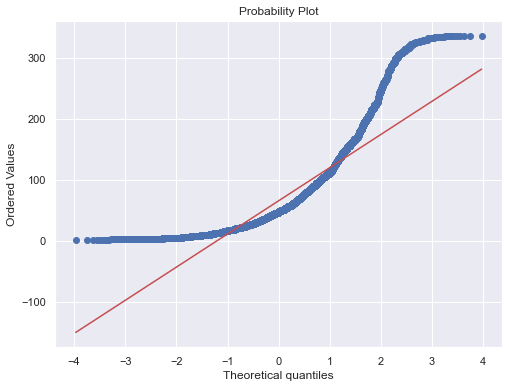

In [107]:
plt.figure(figsize=(9,4))
plt.hist(df_pre["training_hours"], color= sb.color_palette()[0] ,bins=20)
plt.ylabel("Frequency")
plt.title('Training Hours')
plt.show()

df_pre[['training_hours']].boxplot()

plt.figure(figsize = (8,6))
stats.probplot(df_pre['training_hours'], plot = plt)
plt.show()

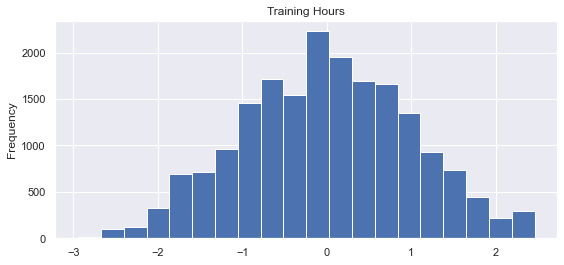

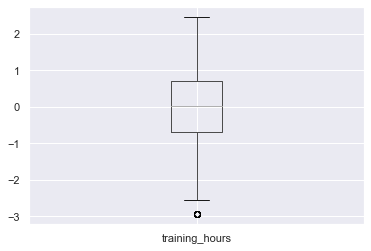

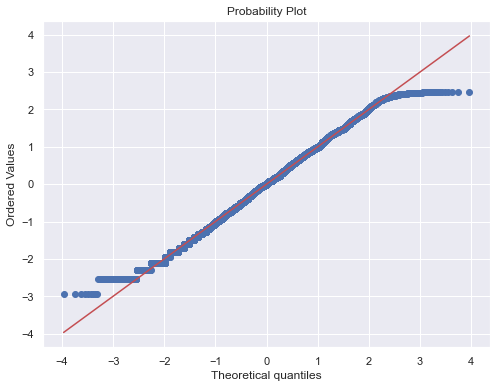

In [108]:
pt = PowerTransformer(method='box-cox')
pt.fit(df_pre['training_hours'].values.reshape(-1,1))
tr = pt.transform(df_pre['training_hours'].values.reshape(-1,1))

df_pre['training_hours'] = pd.DataFrame(tr)

plt.figure(figsize=(9,4))
plt.hist(df_pre["training_hours"], color= sb.color_palette()[0] ,bins=20)
plt.ylabel("Frequency")
plt.title('Training Hours')
plt.show()

df_pre[['training_hours']].boxplot()

plt.figure(figsize = (8,6))
stats.probplot(df_pre['training_hours'], plot = plt)
plt.show()

## City development index

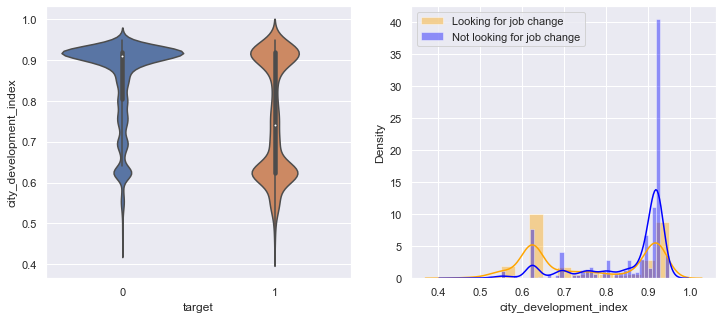

In [109]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
sns.violinplot(x = 'target', y = 'city_development_index', data = df_train)

plt.subplot(1,2,2)
sns.distplot(df_train[df_train['target'] == 1]['city_development_index'][0:] , label = "Looking for job change", color = 'Orange')
sns.distplot(df_train[df_train['target'] == 0]['city_development_index'][0:] , label = "Not looking for job change" , color = 'blue' )
plt.legend()
plt.show();

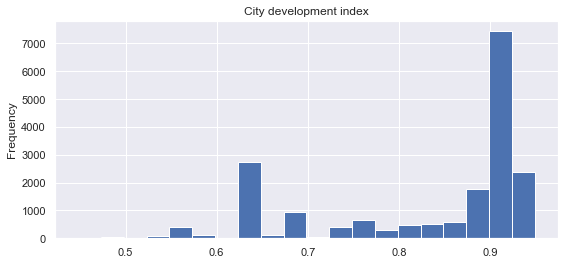

<AxesSubplot:>

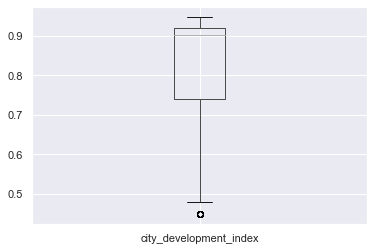

In [110]:
plt.figure(figsize=(9,4))
plt.hist(df_pre["city_development_index"], color= sb.color_palette()[0] ,bins=20)
plt.ylabel("Frequency")
plt.title('City development index')
plt.show()

df_pre[['city_development_index']].boxplot()

##### We need to transform city development index before applying the model

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

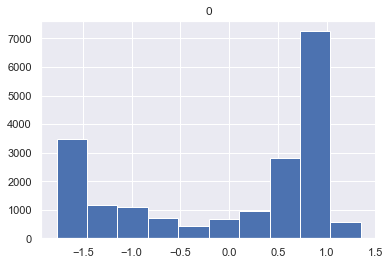

In [111]:
pt = PowerTransformer(method='box-cox')
pt.fit(df_pre['city_development_index'].values.reshape(-1,1))
tr = pt.transform(df_pre['city_development_index'].values.reshape(-1,1))
df_pre['city_development_index'] = pd.DataFrame(tr)
pd.DataFrame(tr).hist()

#pt = PowerTransformer(method='box-cox')
#pt.fit(df_train['training_hours'].values.reshape(-1,1))
#tr = pt.transform(df_train['training_hours'].values.reshape(-1,1))
#df_train['training_hours'] = pd.DataFrame(tr)
#pd.DataFrame(tr).hist()

<AxesSubplot:>

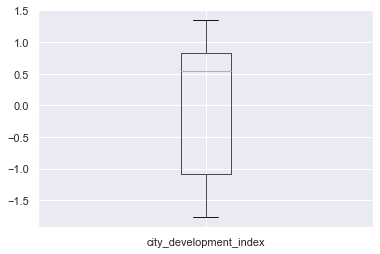

In [112]:
df_pre[['city_development_index']].boxplot()

In [113]:
IQR = df_pre[['city_development_index']].quantile(0.75) - df_pre[['city_development_index']].quantile(0.25)

lower_boundary_1 = df_pre[['city_development_index']].quantile(0.25) - (IQR * 1.5)
upper_boundary_1 = df_pre[['city_development_index']].quantile(0.75) + (IQR * 1.5)
#df=np.where(df_train[['city_development_index']] > upper_boundary, upper_boundary,
#np.where(df_train[['city_development_index']] <lower_boundary, lower_boundary,df_train[['city_development_index']]))
print('city_development_index Lower outliers = ',df_pre.loc[(df_pre['city_development_index']<lower_boundary_1[0])].shape[0])
print('city_development_index Upper outliers = ',df_pre.loc[(df_pre['city_development_index']>upper_boundary_1[0])].shape[0])

city_development_index Lower outliers =  0
city_development_index Upper outliers =  0


#### type of university of education

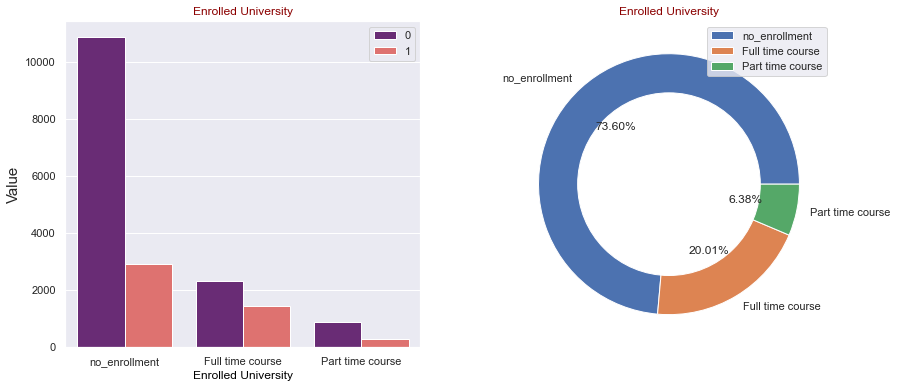

In [114]:
#enrolled_university 
university = df_train["enrolled_university"].value_counts()

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
ax= sns.countplot(df_train["enrolled_university"], hue = "target", data = df_train,palette="magma")
plt.xlabel('Enrolled University', size = 12, color = "black") 
plt.ylabel('Value', size = 15) 
plt.title('Enrolled University', color = "darkred")
plt.legend()

plt.subplot(1,2,2)
circle = plt.Circle((0,0),0.7,color = "white")
plt.pie(university.values, labels = university.index,  autopct='%1.2f%%')
p = plt.gcf()
p.gca().add_artist(circle) 
plt.title("Enrolled University", color = "darkred")
plt.legend()
plt.show()


### Does education level effects?

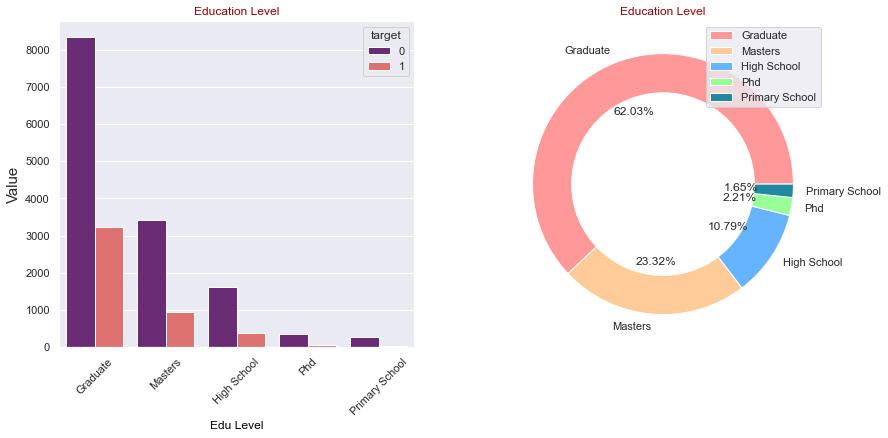

In [115]:
#education_level

# valuecounts(df["education_level"])

edu_level = df_train["education_level"].value_counts()

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
ax = sns.countplot(df_train["education_level"], hue = "target", data = df_train,palette="magma")
plt.xlabel('Edu Level', size = 12, color = "black") 
plt.xticks(rotation = 45)
plt.ylabel('Value', size = 15) 
plt.title('Education Level', color = "darkred")

#add colors
colors = ['#ff9999','#ffcc99','#66b3ff','#99ff99','#22889f']

plt.subplot(1,2,2)
circle = plt.Circle((0,0),0.7,color = "white")
plt.pie(edu_level.values, labels = edu_level.index, colors = colors, autopct='%1.2f%%')
p = plt.gcf()
p.gca().add_artist(circle) 
plt.title("Education Level", color = "darkred")
plt.legend()
plt.show()


#### Gender

Male      13221
Female     1238
Other       191
Name: gender, dtype: int64


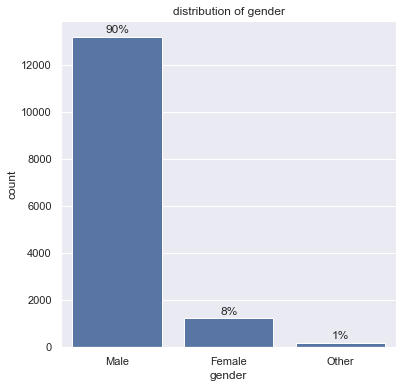

In [116]:

count = df_train.gender.value_counts()
print( count )
plt.figure(figsize = (6,6))
sb.countplot(df_train.gender,color = sb.color_palette()[0]);
plt.title('distribution of gender');
plt.xlabel('gender');
plt.ylabel('count');
for i in range(count.shape[0]):
    plt.text( 
            i,
            count[i] + 500,
            str(round(100*count[i] / df_train.gender.count()))+'%',
              ha='center',
              va = 'top')

#### Relevant Experience

Has relevent experience    13792
No relevent experience      5366
Name: relevent_experience, dtype: int64


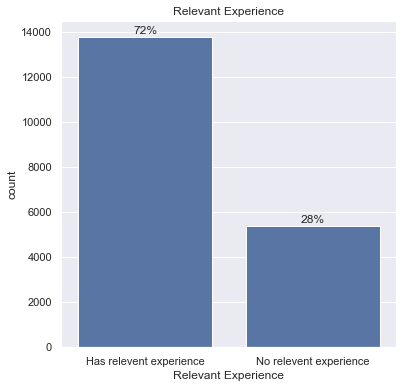

In [117]:
count = df_train.relevent_experience.value_counts()
print( count )
plt.figure(figsize = (6,6))
sb.countplot(df_train.relevent_experience,color = sb.color_palette()[0]);
plt.title('Relevant Experience');
plt.xlabel('Relevant Experience');
plt.ylabel('count');
for i in range(count.shape[0]):
    plt.text( 
            i,
            count[i] + 500,
            str(round(100*count[i] / df_train.relevent_experience.count()))+'%',
              ha='center',
              va = 'top')

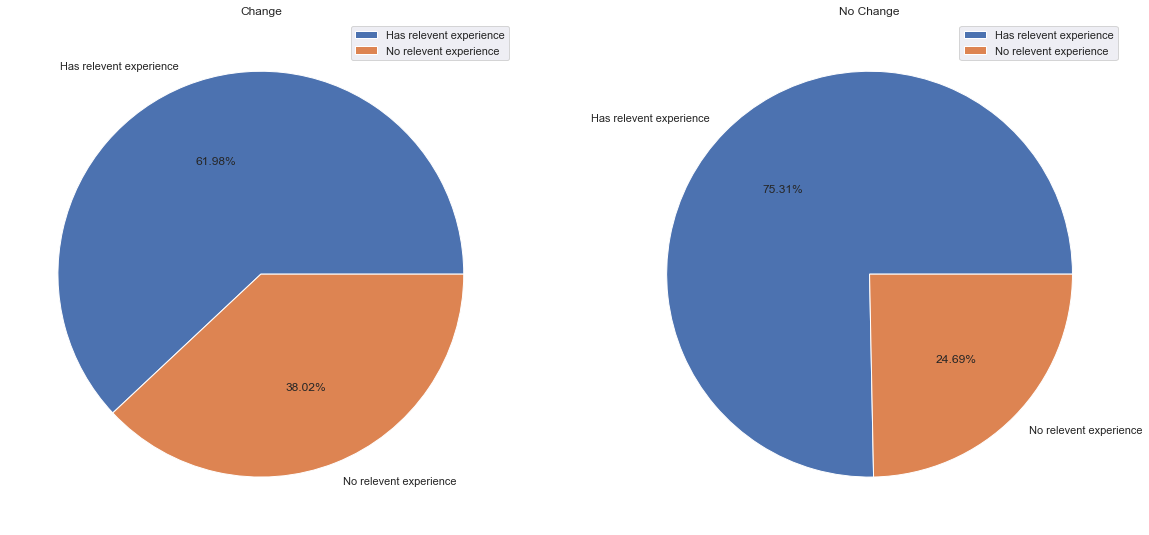

In [118]:
change = df_train[df_train.target == 1].relevent_experience.value_counts()
no_change = df_train[df_train.target == 0].relevent_experience.value_counts()
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.pie(change,autopct='%1.2f%%',labels=change.index)
plt.legend()
plt.title('Change')
plt.subplot(1,2,2)
plt.pie(no_change,autopct='%1.2f%%',labels=no_change.index)
plt.legend()
plt.title('No Change')
plt.show()

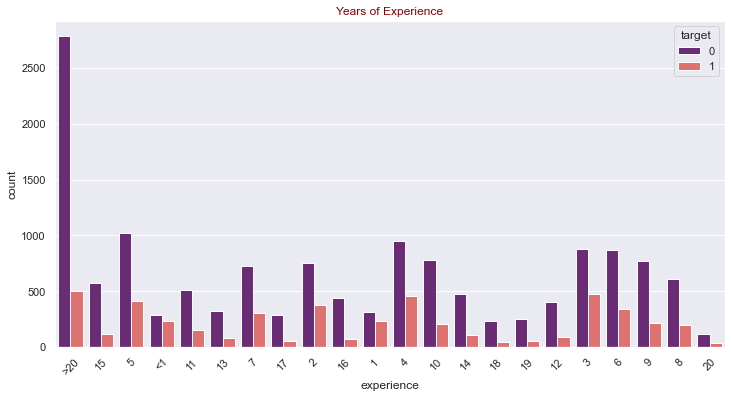

In [119]:
plt.figure(figsize=(12,6))
sns.countplot(df_train["experience"], hue = "target", data = df_train,palette="magma")
plt.xticks(rotation = 45)
plt.title("Years of Experience", color = "darkred")
plt.show()

#### Feature preparation

In [120]:
print(pd.pivot_table(df_pre, values='target',
                    columns=['relevent_experience'], aggfunc=np.sum).T.sort_values('target', ascending=False))

print(pd.pivot_table(df_pre, values='target',
                    columns=['education_level'], aggfunc=np.sum).T.sort_values('target', ascending=False))

print(pd.pivot_table(df_pre, values='target',
                    columns=['enrolled_university'], aggfunc=np.sum).T.sort_values('target', ascending=False))

print(pd.pivot_table(df_pre, values='target',
                    columns=['gender'], aggfunc=np.sum).T.sort_values('target', ascending=False))

print(pd.pivot_table(df_pre, values='target',
                    columns=['major_discipline'], aggfunc=np.sum).T.sort_values('target', ascending=False))

print(pd.pivot_table(df_pre, values='target',
                    columns=['company_type'], aggfunc=np.sum).T.sort_values('target', ascending=False))

                         target
relevent_experience            
Has relevent experience    2961
No relevent experience     1816
                 target
education_level        
Graduate           3245
Masters             935
High School         394
Phd                  58
Primary School       41
                     target
enrolled_university        
no_enrollment          2921
Full time course       1431
Part time course        302
        target
gender        
Male      3012
Female     326
Other       50
                  target
major_discipline        
STEM                3791
Humanities           141
Other                102
Business Degree       86
No Major              55
Arts                  53
                     target
company_type               
Pvt Ltd                1775
Public Sector           210
Early Stage Startup     142
Funded Startup          140
NGO                      97
Other                    29


A lot of background-related differences in these features. We will need to encode them manually to improve the model.

The number of people who change the job vary significantly and inconsistenly!

#### Experience

In [121]:
df_pre['experience'].value_counts()

>20    3286
5      1430
4      1403
3      1354
6      1216
2      1127
7      1028
10      985
9       980
8       802
15      686
11      664
14      586
1       549
<1      522
16      508
12      494
13      399
17      342
19      304
18      280
20      148
Name: experience, dtype: int64

In [122]:
# df_pre['experience'].replace({'1':'1-5',
#                                 '2':'1-5',
#                                 '3':'1-5',
#                                 '4':'1-5',
#                                 '5':'1-5',
#                                 '6':'6-10',
#                                 '7':'6-10',
#                                 '8':'6-10',
#                                 '9':'6-10',
#                                 '10':'6-10',
#                                 '11':'11-15',
#                                 '12':'11-15',
#                                 '13':'11-15',
#                                 '14':'11-15',
#                                 '15':'11-15',
#                                 '16':'16-20',
#                                 '17':'16-20',
#                                 '18':'16-20',
#                                 '19':'16-20',
#                                 '20':'16-20'},inplace=True)

# df_train.experience.value_counts()

In [123]:
# count = df_pre.experience.value_counts()
# print( count )
# plt.figure(figsize=(20,8))
# order=['<1','1-5','6-10','11-15','16-20','>20' ]
# sb.countplot(df_pre.experience ,color = sb.color_palette()[0], order=order );
# plt.title('Experience');
# plt.xlabel('Years of Experience');
# plt.ylabel('count');
# plt.text( 0, count[5]+200 , str(round(100*count[5] / df_pre.experience.count()))+'%', ha='center',va = 'top')
# plt.text( 1, count[0]+200 , str(round(100*count[0] / df_pre.experience.count()))+'%', ha='center',va = 'top')
# plt.text( 2, count[1]+200 , str(round(100*count[1] / df_pre.experience.count()))+'%', ha='center',va = 'top')
# plt.text( 3, count[3]+200 , str(round(100*count[3] / df_pre.experience.count()))+'%', ha='center',va = 'top')
# plt.text( 4, count[4]+200 , str(round(100*count[4] / df_pre.experience.count()))+'%', ha='center',va = 'top')
# plt.text( 5, count[2]+200 , str(round(100*count[2] / df_pre.experience.count()))+'%', ha='center',va = 'top')

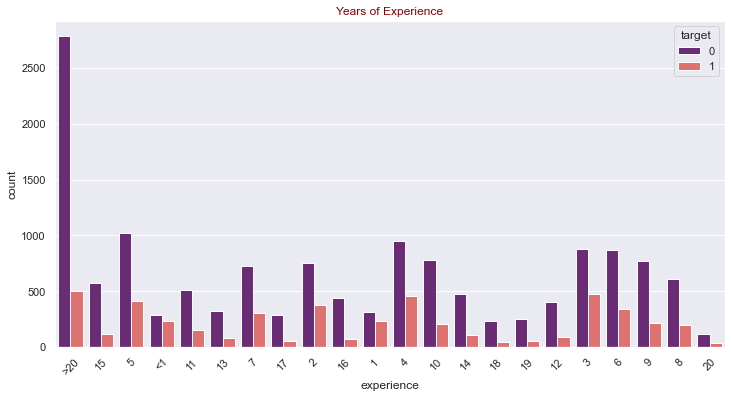

In [124]:
plt.figure(figsize=(12,6))
sns.countplot(df_pre["experience"], hue = "target", data = df_pre,palette="magma")
plt.xticks(rotation = 45)
plt.title("Years of Experience", color = "darkred")
plt.show()

In [125]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  float64
 13  target                  19158 non-null  int64  
dtypes: float64(2), int64(2), object(10)
me

In [126]:

experience_dict = {'Has relevent experience' : 1,
             'No relevent experience': 0}

education_dict = {'Primary School' : 0,
                  'High School' : 1,
                 'Graduate' : 2,
                'Masters' : 3,
                 'Phd' : 4}

enrollment_dict = {'no_enrollment' : 0,
             'Full time course' : 1,
             'Part time course' : 2}

gender_dict = {'Male' : 2,
             'Female' : 1,
             'Other' : 0}

discipline_dict = {'STEM' : 5,
             'Humanities' : 2,
             'Business Degree' : 1,
             'Other' : 4,
             'No Major' : 3,
             'Arts' : 0 }

company_dict = {'Pvt Ltd' : 4,
             'Funded Startup' : 1,
             'Public Sector' : 3,
             'Early Stage Startup' : 0,
             'NGO' : 2,
             'Other' : 5 }

In [127]:
# Train encoding
# le = LabelEncoder()
# df_pre['gender'] = df_pre['gender'].map(gender_dict)
# df_pre['relevent_experience'] = df_pre['relevent_experience'].map(experience_dict)
# df_pre['education_level'] = df_pre['education_level'].map(education_dict)
# df_pre['enrolled_university'] = df_pre['enrolled_university'].map(enrollment_dict)
# df_pre['major_discipline'] = df_pre['major_discipline'].map(discipline_dict)
# df_pre['expercompany_sizeience'] = le.fit_transform(df_pre['experience'].astype(str))
# df_pre[''] = le.fit_transform(df_pre['company_size'].astype(str))
# df_pre['company_type'] = df_pre['company_type'].map(company_dict)

# df_pre['last_new_job'] = le.fit_transform(df_pre['last_new_job'].astype(str))

# df_encod = df_pre

In [128]:
# to_LabelEncode = df_pre[['gender', 'relevent_experience',
#        'enrolled_university', 'education_level', 'major_discipline',
#        'experience', 'company_size', 'company_type', 'last_new_job']]

# le = LabelEncoder()
# df_temp = to_LabelEncode.astype("str").apply(le.fit_transform)
# df_final = df_temp.where(~to_LabelEncode.isna(), to_LabelEncode)

# df_pre.drop(['gender', 'relevent_experience','enrolled_university', 'education_level', 
#                  'major_discipline','experience', 'company_size', 'company_type', 
#                  'last_new_job'],axis=1,inplace=True)

# df_data = df_final.join(df_pre)
# df_data.head()

# df_encod = df_data
# df_encod.drop(["target"], axis=1, inplace = True)
# df_encod.head()

In [129]:
df_pre['experience'] = df_pre['experience'].replace('>20', 21)
df_pre['experience'] = df_pre['experience'].replace('<1', 0)
df_pre['experience'].value_counts()

21    3286
5     1430
4     1403
3     1354
6     1216
2     1127
7     1028
10     985
9      980
8      802
15     686
11     664
14     586
1      549
0      522
16     508
12     494
13     399
17     342
19     304
18     280
20     148
Name: experience, dtype: int64

In [130]:
# test_df['city'] = test_df['city'].split("_")[1]

test_df1 = df_pre['city'].str.split('_',1,expand = True)

# test_df.city.str.split('_')[1][1]
# test_df1.head()

In [131]:
df_pre.drop(["city"], axis=1, inplace = True)


In [132]:
df_pre['city'] = test_df1[1]

In [133]:
df_pre['city'] = df_pre['city'].astype(str).astype(int)

In [134]:
to_LabelEncode = df_pre[['gender','relevent_experience',
       'enrolled_university', 'education_level', 'major_discipline','company_size', 'company_type', 'last_new_job']]

le = LabelEncoder()
df_temp = to_LabelEncode.astype("str").apply(le.fit_transform)
df_temp = df_temp.where(~to_LabelEncode.isna(), to_LabelEncode)

df_encod = df_temp.join(df_pre[['enrollee_id','city_development_index','training_hours','experience','city']])

df_encod.shape

df_encod.head()



,gender,relevent_experience,enrolled_university,education_level,major_discipline,company_size,company_type,last_new_job,enrollee_id,city_development_index,training_hours,experience,city
0,1,0,3,0,5,NaN,NaN,0,8949,0.821326,-0.266673,21,103
1,1,1,3,0,5,4,5,4,29725,-0.848196,0.006630,15,40
2,NaN,1,0,0,5,NaN,NaN,6,11561,-1.543829,0.633284,5,21
3,NaN,1,NaN,0,1,NaN,5,6,33241,-0.749002,0.113587,0,115
4,1,0,3,2,5,4,1,3,666,-0.912240,-1.593722,21,162


In [135]:
# test_df = df_train

In [136]:

# test_df.drop(["city"], axis=1, inplace = True)

In [137]:
# test_df.dtypes

In [138]:
# test_df.city.value_counts()

In [139]:
df_train.city.value_counts()
# df_encod.relevent_experience.value_counts()

103    4355
21     2702
16     1533
114    1336
160     845
       ... 
129       3
111       3
121       3
140       1
171       1
Name: city, Length: 123, dtype: int64

In [140]:
df_encod.city.value_counts()

103    4355
21     2702
16     1533
114    1336
160     845
       ... 
129       3
111       3
121       3
140       1
171       1
Name: city, Length: 123, dtype: int64

In [141]:
# cols=['gender','relevent_experience','enrolled_university','education_level', 'major_discipline',
#        'experience','company_size','company_type','last_new_job']
# for i in cols:
#     df_encod[i] = df_encod[i].astype(float)
# df_encod.boxplot(column=cols,figsize=(40,10))

In [142]:
# df_encod.drop(["city_development_index"], axis=1, inplace = True)

In [143]:
target = df_pre['target']
df_pre = df_encod
df_pre.head()

,gender,relevent_experience,enrolled_university,education_level,major_discipline,company_size,company_type,last_new_job,enrollee_id,city_development_index,training_hours,experience,city
0,1,0,3,0,5,NaN,NaN,0,8949,0.821326,-0.266673,21,103
1,1,1,3,0,5,4,5,4,29725,-0.848196,0.006630,15,40
2,NaN,1,0,0,5,NaN,NaN,6,11561,-1.543829,0.633284,5,21
3,NaN,1,NaN,0,1,NaN,5,6,33241,-0.749002,0.113587,0,115
4,1,0,3,2,5,4,1,3,666,-0.912240,-1.593722,21,162


In [144]:
missing_cols = df_pre.columns[df_pre.isna().any()].tolist()
missing_cols

['gender',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'company_size',
 'company_type',
 'last_new_job',
 'experience']

In [145]:
#dataframe having features with missing values
df_missing = df_pre[['enrollee_id'] + missing_cols]

#dataframe having features without missing values
df_non_missing = df_pre.drop(missing_cols, axis = 1)

In [146]:
# #k-Nearest Neighbour Imputation
# knn_imputer = KNNImputer(n_neighbors = 3)

# X = np.round(knn_imputer.fit_transform(df_missing))
# #Rounding them because these are categorical features

# df_missing = pd.DataFrame(X, columns = df_missing.columns)

# #now lets join both dataframes 
# df_pre2 = pd.merge(df_missing, df_non_missing, on = 'enrollee_id')
# df_pre2.head()
# final_df = df_pre2

# # df_encod.drop(["target"], axis = 1, inplace = True)

In [147]:
lr = LinearRegression()

mice_imputer = IterativeImputer(random_state=42, estimator=lr, max_iter=10,
                         n_nearest_features=2,skip_complete=True)

final_df = mice_imputer.fit_transform(df_encod)

final_df = pd.DataFrame(final_df)
# print(final_df['gender'].max())
print(final_df.shape)
# final_df.columns = ['gender','relevent_experience', 'enrollee_id', 'enrolled_university', 'education_level', 
#                     'major_discipline','experience', 'company_size', 'company_type', 
#                     'last_new_job','city_development_index','training_hours']

final_df.columns = df_encod.columns

print(final_df['gender'].max())
final_df.head()


(19158, 13)
2.0


,gender,relevent_experience,enrolled_university,education_level,major_discipline,company_size,company_type,last_new_job,enrollee_id,city_development_index,training_hours,experience,city
0,1.000000,0.0,3.000000,0.0,5.0,3.050900,4.282647,0.0,8949.0,0.821326,-0.266673,21.0,103.0
1,1.000000,1.0,3.000000,0.0,5.0,4.000000,5.000000,4.0,29725.0,-0.848196,0.006630,15.0,40.0
2,0.920906,1.0,0.000000,0.0,5.0,3.050900,4.101583,6.0,11561.0,-1.543829,0.633284,5.0,21.0
3,0.898444,1.0,1.599849,0.0,1.0,3.113412,5.000000,6.0,33241.0,-0.749002,0.113587,0.0,115.0
4,1.000000,0.0,3.000000,2.0,5.0,4.000000,1.000000,3.0,666.0,-0.912240,-1.593722,21.0,162.0


#### After imputation

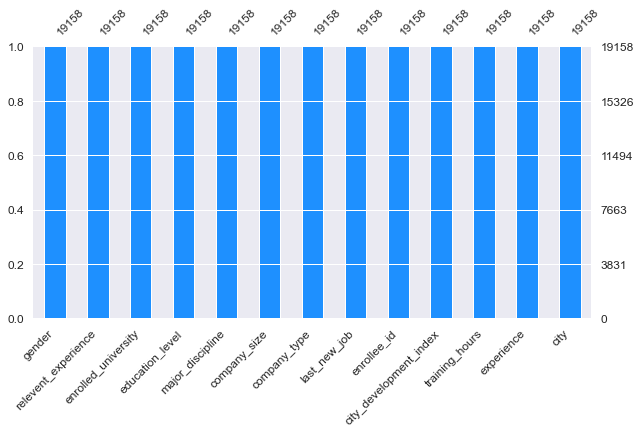

In [148]:
msno.bar(final_df,color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

In [149]:
final_df = final_df.join(target)
final_df.head()

,gender,relevent_experience,enrolled_university,education_level,major_discipline,company_size,company_type,last_new_job,enrollee_id,city_development_index,training_hours,experience,city,target
0,1.000000,0.0,3.000000,0.0,5.0,3.050900,4.282647,0.0,8949.0,0.821326,-0.266673,21.0,103.0,1
1,1.000000,1.0,3.000000,0.0,5.0,4.000000,5.000000,4.0,29725.0,-0.848196,0.006630,15.0,40.0,0
2,0.920906,1.0,0.000000,0.0,5.0,3.050900,4.101583,6.0,11561.0,-1.543829,0.633284,5.0,21.0,0
3,0.898444,1.0,1.599849,0.0,1.0,3.113412,5.000000,6.0,33241.0,-0.749002,0.113587,0.0,115.0,1
4,1.000000,0.0,3.000000,2.0,5.0,4.000000,1.000000,3.0,666.0,-0.912240,-1.593722,21.0,162.0,0


In [150]:
final_df['gender'] = final_df['gender'].round(0)
final_df.head()

,gender,relevent_experience,enrolled_university,education_level,major_discipline,company_size,company_type,last_new_job,enrollee_id,city_development_index,training_hours,experience,city,target
0,1.0,0.0,3.000000,0.0,5.0,3.050900,4.282647,0.0,8949.0,0.821326,-0.266673,21.0,103.0,1
1,1.0,1.0,3.000000,0.0,5.0,4.000000,5.000000,4.0,29725.0,-0.848196,0.006630,15.0,40.0,0
2,1.0,1.0,0.000000,0.0,5.0,3.050900,4.101583,6.0,11561.0,-1.543829,0.633284,5.0,21.0,0
3,1.0,1.0,1.599849,0.0,1.0,3.113412,5.000000,6.0,33241.0,-0.749002,0.113587,0.0,115.0,1
4,1.0,0.0,3.000000,2.0,5.0,4.000000,1.000000,3.0,666.0,-0.912240,-1.593722,21.0,162.0,0


In [151]:
final_df.duplicated().sum()

0

<AxesSubplot:>

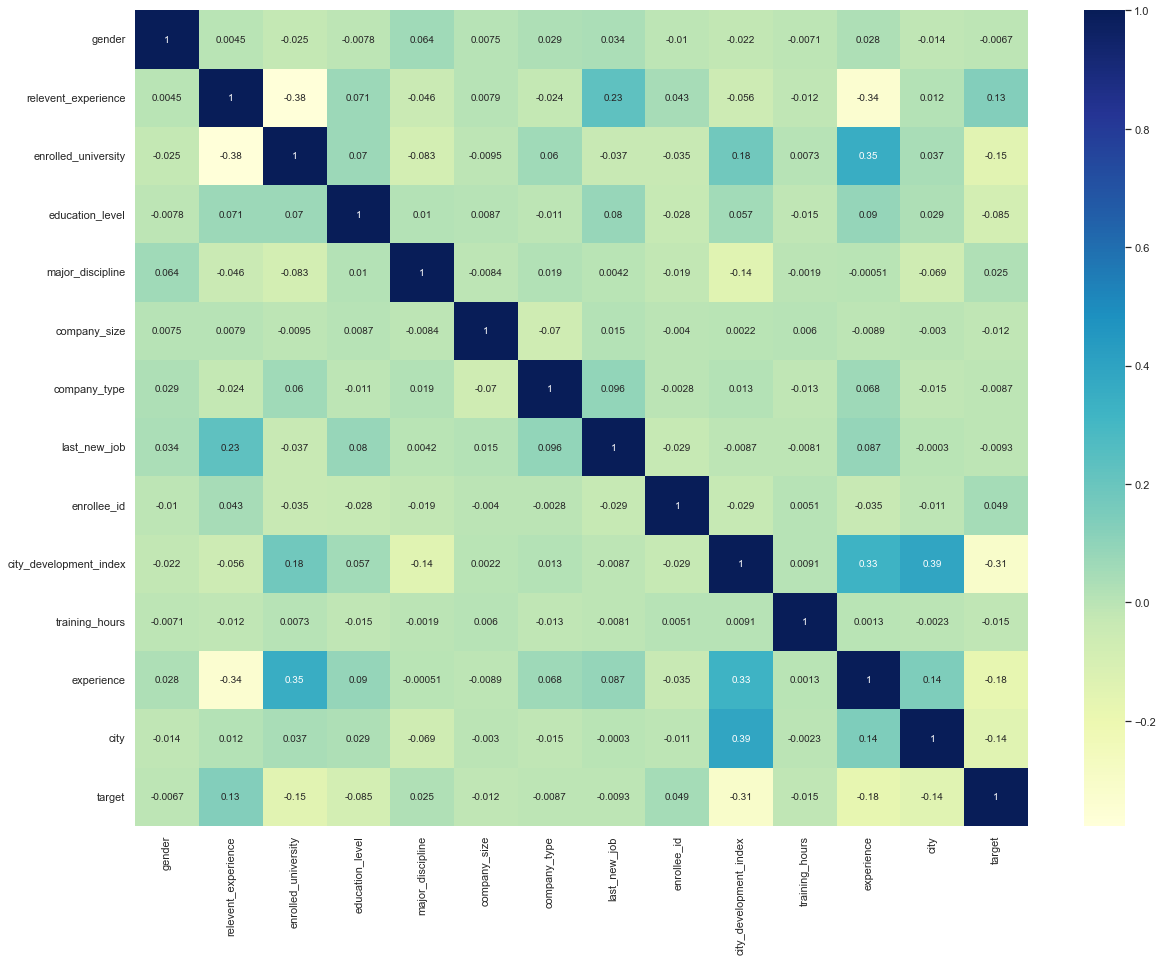

In [152]:
plt.subplots(figsize=(20,15))
sb.heatmap(final_df.corr(),annot_kws={"size": 10} ,annot=True,cmap='YlGnBu',)

#### Apply One Hot Encoding to gender column

In [153]:
# print(final_df['gender'].max())
# final_df['gender']=(final_df['gender'].apply(np.ceil)).astype(int)
# final_df['gender'].max()

In [154]:
# encoder = OneHotEncoder(handle_unknown='ignore')

# #perform one-hot encoding on 'team' column 
# encoder_df = pd.DataFrame(encoder.fit_transform(final_df[['gender']]).toarray())

# #merge one-hot encoded columns back with original DataFrame
# encoder_df.columns = ['gender_f','gender_m','gender_oth']


# final_df.drop(columns='gender',inplace=True)
# final_df = pd.DataFrame(final_df.join(encoder_df))
# #view final df
# final_df.head()

#### Correlation after Filling Nulls

<AxesSubplot:>

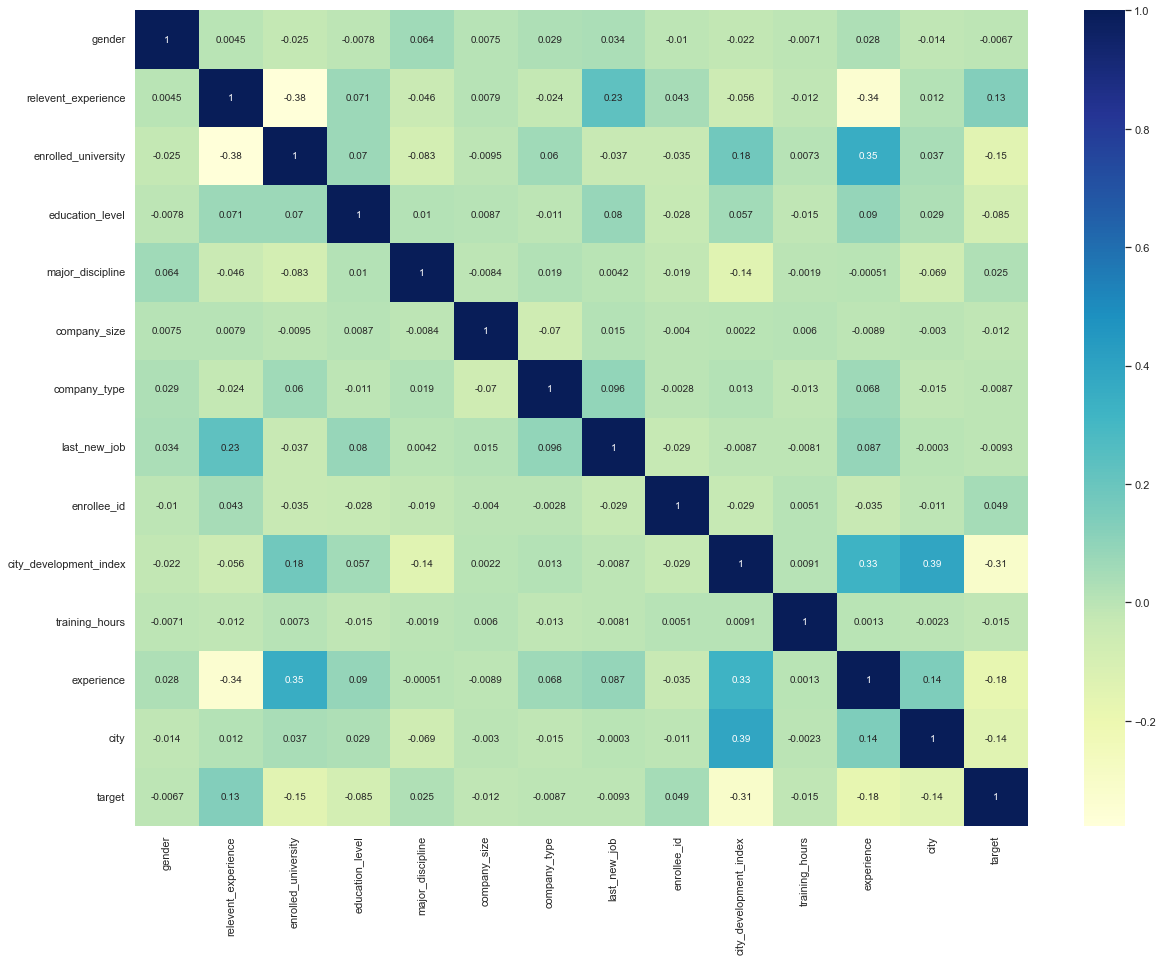

In [155]:
plt.subplots(figsize=(20,15))
sb.heatmap(final_df.corr(),annot_kws={"size": 10} ,annot=True,cmap='YlGnBu',)

In [156]:
train = final_df[final_df['target'] != -1].reset_index(drop = True)
test = final_df[final_df['target'] == -1].reset_index(drop = True)
train.head()
X = train.drop(['enrollee_id', 'target'], axis = 1)
Y = train['target']

# # drop fake target feature from test data 
test = test.drop('target', axis = 1)

# train.head()

#############################################################################
# train = final_df
#####################################################################

<AxesSubplot:xlabel='target', ylabel='count'>

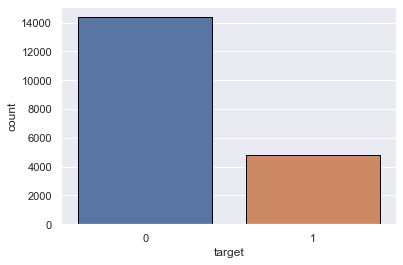

In [157]:
sns.countplot(train['target'], edgecolor = 'black')

#### Checking for imbalance

0    14381
1     4777
Name: target, dtype: int64


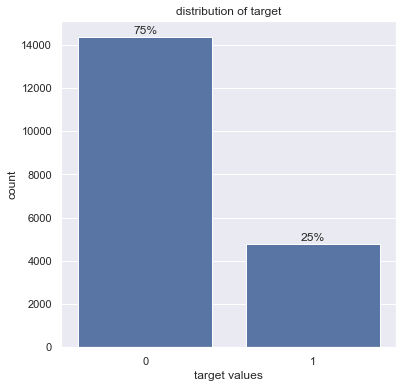

In [158]:
count = train.target.value_counts()
print( count )
plt.figure(figsize = (6,6))
sb.countplot(train.target,color = sb.color_palette()[0]);
plt.title('distribution of target');
plt.xlabel('target values');
plt.ylabel('count');
for i in range(count.shape[0]):
    plt.text( 
            i,
            count[i] + 500,
            str(round(100*count[i] /train.target.count()))+'%',
              ha='center',
              va = 'top')
    

In [159]:
#############################################################################
# train_all = final_df
#####################################################################
train.drop(["enrollee_id"], axis = 1, inplace = True)
final_df = train
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  19158 non-null  float64
 1   relevent_experience     19158 non-null  float64
 2   enrolled_university     19158 non-null  float64
 3   education_level         19158 non-null  float64
 4   major_discipline        19158 non-null  float64
 5   company_size            19158 non-null  float64
 6   company_type            19158 non-null  float64
 7   last_new_job            19158 non-null  float64
 8   city_development_index  19158 non-null  float64
 9   training_hours          19158 non-null  float64
 10  experience              19158 non-null  float64
 11  city                    19158 non-null  float64
 12  target                  19158 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 1.9 MB


In [160]:


# final_df.drop(["company_size"], axis = 1, inplace = True)
# final_df.drop(["last_new_job"], axis = 1, inplace = True)

final_df.head()
# final_df["last_new_job"].unique()

,gender,relevent_experience,enrolled_university,education_level,major_discipline,company_size,company_type,last_new_job,city_development_index,training_hours,experience,city,target
0,1.0,0.0,3.000000,0.0,5.0,3.050900,4.282647,0.0,0.821326,-0.266673,21.0,103.0,1
1,1.0,1.0,3.000000,0.0,5.0,4.000000,5.000000,4.0,-0.848196,0.006630,15.0,40.0,0
2,1.0,1.0,0.000000,0.0,5.0,3.050900,4.101583,6.0,-1.543829,0.633284,5.0,21.0,0
3,1.0,1.0,1.599849,0.0,1.0,3.113412,5.000000,6.0,-0.749002,0.113587,0.0,115.0,1
4,1.0,0.0,3.000000,2.0,5.0,4.000000,1.000000,3.0,-0.912240,-1.593722,21.0,162.0,0


In [161]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  19158 non-null  float64
 1   relevent_experience     19158 non-null  float64
 2   enrolled_university     19158 non-null  float64
 3   education_level         19158 non-null  float64
 4   major_discipline        19158 non-null  float64
 5   company_size            19158 non-null  float64
 6   company_type            19158 non-null  float64
 7   last_new_job            19158 non-null  float64
 8   city_development_index  19158 non-null  float64
 9   training_hours          19158 non-null  float64
 10  experience              19158 non-null  float64
 11  city                    19158 non-null  float64
 12  target                  19158 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 1.9 MB


In [78]:
y_true = final_df["target"]
final_df["target"].value_counts(normalize=True)
X = final_df.drop('target',1)
y = final_df.target

# svm_smote = SMOTE( random_state=42,k_neighbors=5) #,sampling_strategy='minority', k_neighbors=5)
# X_svm_smote, y_svm_smote = svm_smote.fit_resample(X,y)

# X_train_svm, X_test_svm, y_train, y_test = train_test_split(X_svm_smote,y_svm_smote, test_size=0.3, random_state=42)

svm_smote = SMOTE( random_state=101) #,sampling_strategy='minority', k_neighbors=5)
X_svm_smote, y_svm_smote = svm_smote.fit_resample(X,y)

X_train_svm, X_test_svm, y_train, y_test = train_test_split(X_svm_smote,y_svm_smote, test_size=0.20, random_state=101)

In [79]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train_svm)
X_test = sc.transform(X_test_svm)

print("Number of data points in train data :",X_train.shape)
print("Number of data points in validation data :",X_test.shape)
print(X_train.mean())

Number of data points in train data : (23009, 12)
Number of data points in validation data : (5753, 12)
2.525814880947087e-17


### Data After oversampling

1    14381
0    14381
Name: target, dtype: int64


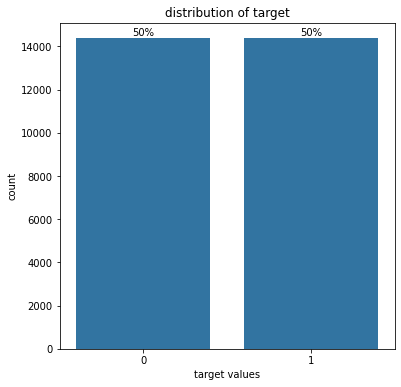

In [80]:
count = y_svm_smote.value_counts()
print( count )
plt.figure(figsize = (6,6))
sb.countplot(y_svm_smote,color = sb.color_palette()[0]);
plt.title('distribution of target');
plt.xlabel('target values');
plt.ylabel('count');
for i in range(count.shape[0]):
    plt.text( 
            i,
            count[i] + 500,
            str(round(100*count[i] /y_svm_smote.count()))+'%',
              ha='center',
              va = 'top')

In [81]:
print("X_train",X_train.shape)
print("X_test",X_test.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape)

X_train (23009, 12)
X_test (5753, 12)
y_train (23009,)
y_test (5753,)


In [82]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    
    #divide each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    # Initialise the subplot function using number of rows and columns

    sns.set(font_scale=1)
    labels = [0,1]
    # representing A in heatmap format
    cmap1=sns.light_palette("orange")
    cmap2=sns.light_palette("#34c3eb")
    cmap3=sns.light_palette("purple")
    
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap1, fmt=".3f", xticklabels=labels, yticklabels=labels,annot_kws={"size":14})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
#     plt.subplot(1, 3, 2)
#     sns.heatmap(B, annot=True, cmap=cmap2, fmt=".3f", xticklabels=labels, yticklabels=labels,annot_kws={"size":14})
#     plt.xlabel('Predicted Class')
#     plt.ylabel('Original Class')
#     plt.title("Precision matrix")
    
#     plt.subplot(1, 3, 3)
#     # representing B in heatmap format
#     sns.heatmap(A, annot=True, cmap=cmap3, fmt=".3f", xticklabels=labels, yticklabels=labels,annot_kws={"size":14})
#     plt.xlabel('Predicted Class')
#     plt.ylabel('Original Class')
#     plt.title("Recall matrix")
    
    plt.show()


def plot_roc_auc(y_test,y_pred):
    from plot_metric.functions import BinaryClassification
    # Visualisation with plot_metric
    bc = BinaryClassification(y_test, y_pred, labels=["Class 1", "Class 0"])

    # Figures
    plt.figure(figsize=(8,7))
    bc.plot_roc_curve()
    
    plt.show()    

In [83]:
# model accuracy
result = []

In [87]:

# parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               'objective':['binary:logistic'],
#               'learning_rate': [0.05], #so called `eta` value
#               'max_depth': [6],
#               'min_child_weight': [1],
#               'silent': [1],
#               'subsample': [0.9],
#               'colsample_bytree':  [0.9],
#               'n_estimators': [1000], #number of trees, change it to 1000 for better results
#               'seed': [27],
#              'gamma': [0]}

# 0.8593
# parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               'objective':['binary:logistic'],
#               'learning_rate': [0.08], #so called `eta` value
#               'max_depth': [3],
#               'min_child_weight': [1],
#               'silent': [1],
#               'subsample': [0.8],
#               'colsample_bytree': [0.7],
#               'n_estimators': [1000], #number of trees, change it to 1000 for better results
#               'seed': [27],
#              'gamma': [0]}

# XGBoost
parameters = {'nthread':[4],
              'objective':['binary:logistic'],
              'learning_rate': [0.08],
              'max_depth': [4],
              'min_child_weight': [1],
              'silent': [1],
              'subsample': [0.9],
              'colsample_bytree': [0.7],
              'n_estimators': [1000],
              'seed': [27],
             'gamma': [0]}

XGB = xgb.XGBClassifier()
XGB = GridSearchCV(XGB, parameters, cv = StratifiedKFold(5, shuffle=True), 
                   scoring='roc_auc',
                   verbose=1, refit=True)

In [88]:
# XGB = CalibratedClassifierCV(XGB, method="sigmoid")
XGB.fit(X_train, y_train)

print(f"Best parameters : \n\n{XGB.best_params_}")
y_pred_xgb = XGB.predict(X_test)
cm_xgb = confusion_matrix(y_pred_xgb,y_test)
fscore = f1_score(y_test,y_pred_xgb)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(acc_xgb)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[23:53:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[23:53:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[23:54:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[23:54:16] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[23:54:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
P

XGBoost Model Accuracy :  0.8656
XGBoost Model F1-score :  0.8645
Classification Report :
               precision    recall  f1-score   support

           0       0.86      0.87      0.87      2895
           1       0.87      0.86      0.86      2858

    accuracy                           0.87      5753
   macro avg       0.87      0.87      0.87      5753
weighted avg       0.87      0.87      0.87      5753



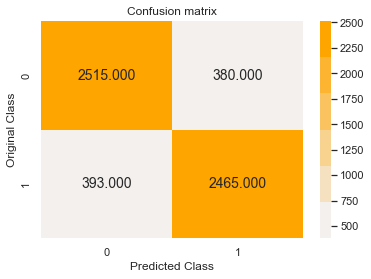

In [86]:
print("XGBoost Model Accuracy : ",round(acc_xgb,4))
print("XGBoost Model F1-score : ",round(fscore,4))
print("Classification Report :\n",classification_report(y_test,y_pred_xgb))
# print('\n')

# print(acc_xgb)
plot_confusion_matrix(y_test, y_pred_xgb)